In [130]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib import ticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import rcParams
from matplotlib import patches
import scipy.io
import astropy.constants as const
import juanfit
import copy
from scipy import interpolate
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.integrate import simps
from scipy.signal import find_peaks
rcParams['axes.linewidth'] = 1.5
import cmcrameri.cm as cmcm
import h5py
from astropy.visualization import ZScaleInterval, ImageNormalize, LogStretch, AsymmetricPercentileInterval,\
         ManualInterval, SqrtStretch
import corner

In [2]:
def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=(1.02, 0., 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

In [3]:
awsom_data_set = scipy.io.readsav(r'../../sav/AWSoM/streamer_test/box_var_8_n00080000.sav',verbose = True,python_dict=True)

--------------------------------------------------
Date: Fri Nov 11 12:04:51 2022
User: yjzhu
Host: 0587449807.wireless.umich.net
--------------------------------------------------
Format: 11
Architecture: x86_64
Operating System: darwin
IDL Version: 8.2
--------------------------------------------------
Successfully read 6 records of which:
 - 1 are of type VERSION
 - 3 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - x [<class 'numpy.ndarray'>]
 - w [<class 'numpy.ndarray'>]
 - param [<class 'numpy.ndarray'>]
--------------------------------------------------


In [4]:
m_p = const.m_p.cgs.value
k_b = const.k_B.cgs.value
c = const.c.cgs.value
rs = const.R_sun.cgs.value

In [5]:
p_e_ratio = 0.83
awsom_x = awsom_data_set['x'][0,0,0,:]
awsom_y = awsom_data_set['x'][1,0,:,0]
awsom_z = awsom_data_set['x'][2,:,0,0]
awsom_x_grid = awsom_data_set['x'][0,:,:,:]
awsom_y_grid = awsom_data_set['x'][1,:,:,:]
awsom_z_grid = awsom_data_set['x'][2,:,:,:]
rho = awsom_data_set['w'][0,:,:,:]
n = rho/m_p
#n = np.nan_to_num(n,nan=0)
ux = awsom_data_set['w'][1,:,:,:]
uy = awsom_data_set['w'][2,:,:,:]
uz = awsom_data_set['w'][3,:,:,:]
bx = awsom_data_set['w'][4,:,:,:]
by = awsom_data_set['w'][5,:,:,:]
bz = awsom_data_set['w'][6,:,:,:]
I01 = awsom_data_set['w'][8,:,:,:]
I02 = awsom_data_set['w'][9,:,:,:]
p = awsom_data_set['w'][11,:,:,:]
t = p/n/k_b
#t = np.nan_to_num(t,nan=1e3)
p_e = awsom_data_set['w'][10,:,:,:]
t_e = p_e/n/k_b
t_e = np.nan_to_num(t_e,nan=1e3)
n = np.nan_to_num(n,nan=1)
n = n + 1
b_tot = np.sqrt(np.square(bx) + np.square(by) + np.square(bz))
u_tot = np.sqrt(np.square(ux) + np.square(uy) + np.square(uz))
bx_rot = np.zeros_like(bx)
by_rot = np.zeros_like(by)
bz_rot = np.zeros_like(bz)
ux_rot = np.zeros_like(ux)
uy_rot = np.zeros_like(uy)
uz_rot = np.zeros_like(uz)

rot_DD = np.resize(awsom_data_set["param"],(3,3))
for ii in range(ux.shape[0]):
    for jj in range(ux.shape[1]):
        for kk in range(ux.shape[2]):
            bx_rot[ii,jj,kk],by_rot[ii,jj,kk],bz_rot[ii,jj,kk] = np.matmul([bx[ii,jj,kk],by[ii,jj,kk],bz[ii,jj,kk]],rot_DD.T)
            ux_rot[ii,jj,kk],uy_rot[ii,jj,kk],uz_rot[ii,jj,kk] = np.matmul([ux[ii,jj,kk],uy[ii,jj,kk],uz[ii,jj,kk]],rot_DD.T)

/var/folders/9p/kj06pc4s4m30vcklbzw2hhgw0000gn/T/ipykernel_46726/2558167840.py:20: RuntimeWarning: invalid value encountered in divide
  t = p/n/k_b
/var/folders/9p/kj06pc4s4m30vcklbzw2hhgw0000gn/T/ipykernel_46726/2558167840.py:23: RuntimeWarning: invalid value encountered in divide
  t_e = p_e/n/k_b


In [55]:
chianti_emiss_tbl = scipy.io.readsav("../../sav/AWSoM/chianti_table/FeXIV_FeX_emiss.sav",verbose=True,python_dict=True)

--------------------------------------------------
Date: Mon Nov 14 17:59:20 2022
User: yjzhu
Host: ptolemy.engin.umich.edu
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.7.2
--------------------------------------------------
Successfully read 8 records of which:
 - 1 are of type VERSION
 - 5 are of type VARIABLE
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - fexiv_emiss_array [<class 'numpy.ndarray'>]
 - fex_emiss_array [<class 'numpy.ndarray'>]
 - temp [<class 'numpy.ndarray'>]
 - dens [<class 'numpy.ndarray'>]
 - height [<class 'numpy.ndarray'>]
--------------------------------------------------


In [7]:
t_e.shape

(169, 96, 301)

In [17]:
awsom_z.shape

(169,)

In [9]:
height_grid = np.sqrt(awsom_x_grid**2 + awsom_y_grid**2 + awsom_z_grid**2)

In [131]:
FeXIV_emiss_func = interpolate.RegularGridInterpolator(points=(chianti_emiss_tbl["height"],chianti_emiss_tbl["dens"],chianti_emiss_tbl["temp"]),
                    values=chianti_emiss_tbl["fexiv_emiss_array"],
                    bounds_error=False,method="linear")
FeXIV_emiss_box = FeXIV_emiss_func((height_grid[:,:,:], np.log10(n[:,:,:]), np.log10(t_e[:,:,:])))

In [134]:
chianti_emiss_tbl["fexiv_emiss_array"].shape

(21, 9, 100)

In [136]:
chianti_emiss_tbl["dens"]

array([ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.], dtype=float32)

In [143]:
chianti_emiss_tbl["temp"][40]

6.0

In [89]:
FeXIV_emiss_func_cubic = interpolate.RegularGridInterpolator(points=(chianti_emiss_tbl["height"],chianti_emiss_tbl["dens"],chianti_emiss_tbl["temp"]),
                    values=chianti_emiss_tbl["fexiv_emiss_array"],
                    bounds_error=False,method="cubic")
FeXIV_emiss_box_cubic = FeXIV_emiss_func_cubic((height_grid[:,:,:], np.log10(n[:,:,:]), np.log10(t_e[:,:,:])))

with h5py.File("../../sav/AWSoM/streamer_test/FeXIV_emiss_test_cubic.h5", 'w') as hf:
    df_FeXIV_emiss = hf.create_dataset("FeXIV_emiss_cubic",  data=FeXIV_emiss_box_cubic)

In [192]:
FeXIV_logemiss_func_cubic = interpolate.RegularGridInterpolator(points=(chianti_emiss_tbl["height"],chianti_emiss_tbl["dens"],chianti_emiss_tbl["temp"]),
                    values=np.log10(chianti_emiss_tbl["fexiv_emiss_array"]+1e-40),
                    bounds_error=False,method="cubic")

In [187]:
def compare_interp(param,table,linear_func,cubic_func,logcubic_func,height_index=None,dens_index=None,temp_index=None):
    x_points = table[param]
    x_points_to_plot = np.linspace(x_points[0],x_points[-1],201)
    if param == "height":
        table_cut = table["fexiv_emiss_array"][:,dens_index,temp_index]
        dens = table["dens"][dens_index]*np.ones(201)
        temp = table["temp"][temp_index]*np.ones(201)
        linear_fit = linear_func((x_points_to_plot,dens,temp))
        cubic_fit = cubic_func((x_points_to_plot,dens,temp))
        logcubic_fit = np.power(10,logcubic_func((x_points_to_plot,dens,temp)))
        title = r"$\log N_e: {:.2f} \log T_e {:.2f}$".format(dens[0],temp[0])
    elif param == "dens":
        table_cut = table["fexiv_emiss_array"][height_index,:,temp_index]
        height = table["height"][height_index]*np.ones(201)
        temp = table["temp"][temp_index]*np.ones(201)
        linear_fit = linear_func((height,x_points_to_plot,temp))
        cubic_fit = cubic_func((height,x_points_to_plot,temp))
        logcubic_fit = np.power(10,logcubic_func((height,x_points_to_plot,temp)))
        title = r"$R_\odot {:.2f} \log T_e {:.2f}$".format(height[0],temp[0])
    elif param == "temp":
        table_cut = table["fexiv_emiss_array"][height_index,dens_index,:]
        dens = table["dens"][dens_index]*np.ones(201)
        height = table["height"][height_index]*np.ones(201)
        linear_fit = linear_func((height,dens,x_points_to_plot))
        cubic_fit = cubic_func((height,dens,x_points_to_plot))
        logcubic_fit = np.power(10,logcubic_func((height,dens,x_points_to_plot)))
        title = r"$R_\odot {:.2f} \log N_e: {:.2f}$".format(height[0],dens[0])
    
    fig, ax = plt.subplots(figsize=(6,4),constrained_layout=True)
    ax.scatter(x_points,table_cut)
    ax.plot(x_points_to_plot,linear_fit,label="linear")
    ax.plot(x_points_to_plot,cubic_fit,label="cubic")
    ax.plot(x_points_to_plot,logcubic_fit,label="logcubic")
    ax.legend(fontsize=14,frameon=False)
    ax.set_xlabel(param,fontsize=14)
    ax.tick_params(labelsize=14)
    ax.set_yscale("log")
    ax.set_title(title,fontsize=14)

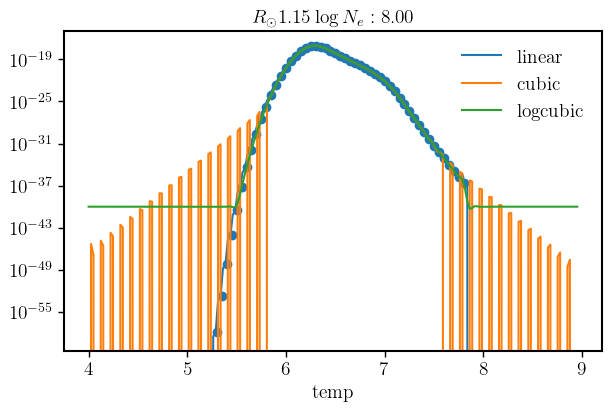

In [193]:
compare_interp("temp",chianti_emiss_tbl,FeXIV_emiss_func,FeXIV_emiss_func_cubic,FeXIV_logemiss_func_cubic,height_index=3,dens_index=3)

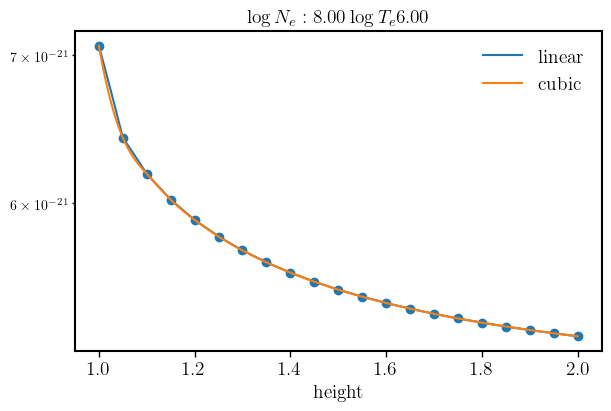

In [174]:
compare_interp("height",chianti_emiss_tbl,FeXIV_emiss_func,FeXIV_emiss_func_cubic,temp_index=40,dens_index=3)

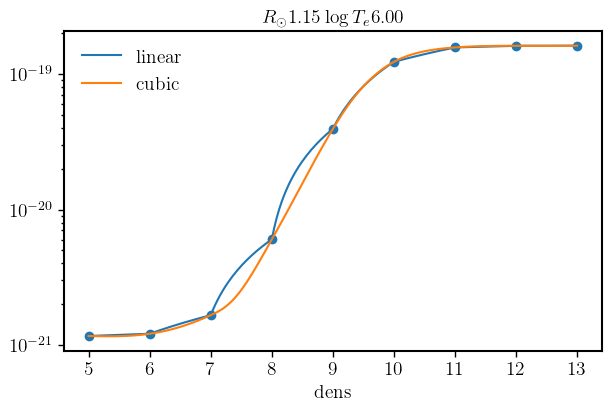

In [175]:
compare_interp("dens",chianti_emiss_tbl,FeXIV_emiss_func,FeXIV_emiss_func_cubic,temp_index=40,height_index=3,
                )

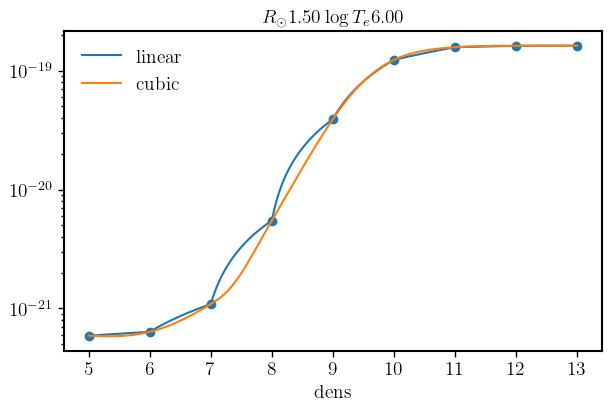

In [161]:
compare_interp("dens",chianti_emiss_tbl,FeXIV_emiss_func,FeXIV_emiss_func_cubic,temp_index=40,height_index=10)

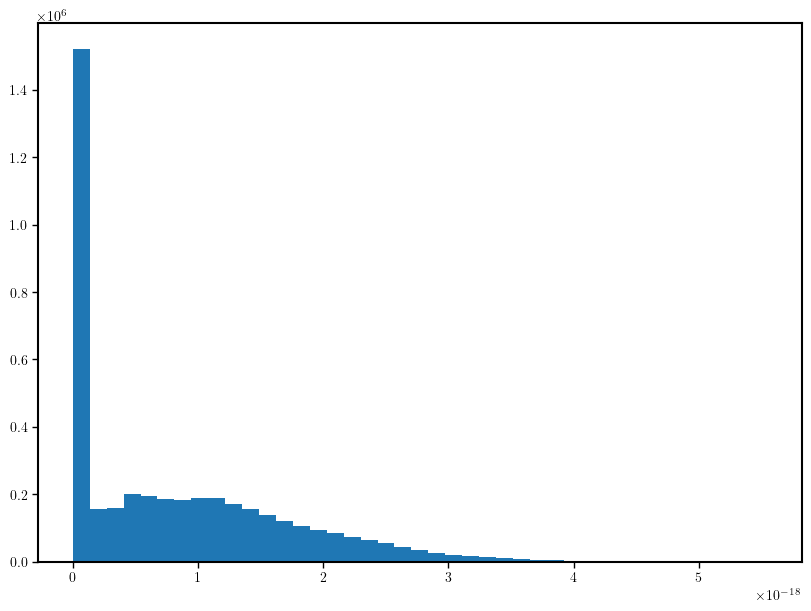

In [101]:
FeXIV_emiss_diff = (FeXIV_emiss_box - FeXIV_emiss_box_cubic)/FeXIV_emiss_box_cubic
fig, ax = plt.subplots(figsize=(8,6),constrained_layout=True)
_ = ax.hist(FeXIV_emiss_box_cubic.flatten(),bins=41)

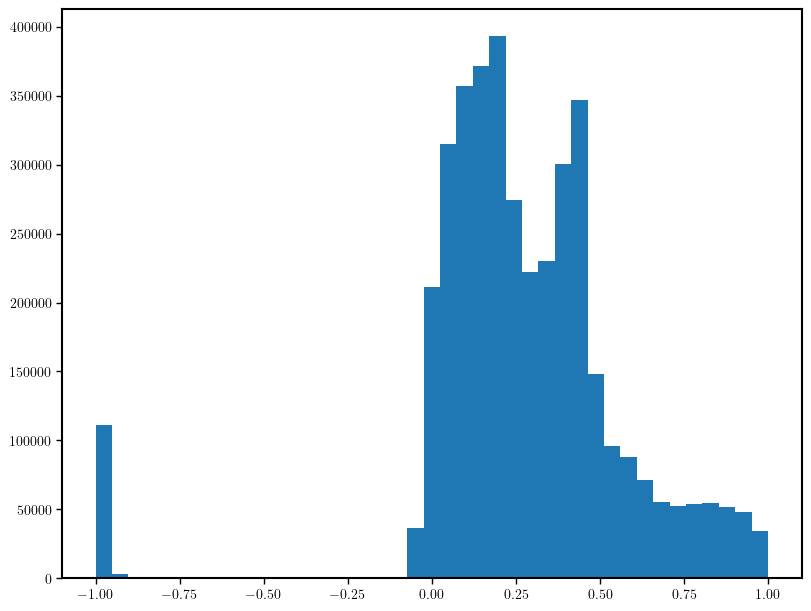

In [93]:
FeXIV_emiss_diff = (FeXIV_emiss_box - FeXIV_emiss_box_cubic)/FeXIV_emiss_box_cubic
fig, ax = plt.subplots(figsize=(8,6),constrained_layout=True)
_ = ax.hist(FeXIV_emiss_diff.flatten(),bins=41,range=(-1,1))

/anaconda3/envs/xarray/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: AutoMinorLocator does not work with logarithmic scale
  func(*args, **kwargs)
/anaconda3/envs/xarray/lib/python3.9/site-packages/IPython/core/events.py:89: UserWarning: AutoMinorLocator does not work with logarithmic scale
  func(*args, **kwargs)
/anaconda3/envs/xarray/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: AutoMinorLocator does not work with logarithmic scale
  fig.canvas.print_figure(bytes_io, **kw)


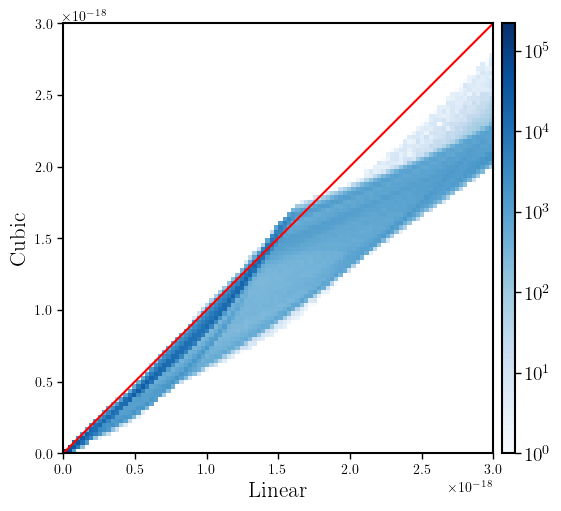

In [126]:
fig, ax = plt.subplots(figsize=(6,5),constrained_layout=True)
_, _, _, im = ax.hist2d(FeXIV_emiss_box.flatten(),FeXIV_emiss_box_cubic.flatten(),bins=[100,100],
            range=[[0, 3e-18],[0, 3e-18]],norm=colors.LogNorm(vmax=2.2e5),cmap="Blues")
plot_colorbar(im,ax)
ax.set_xlabel("Linear",fontsize=16)
ax.set_ylabel("Cubic",fontsize=16)
ax.set_aspect(1)
ax.plot([0,3e-18],[0,3e-18],color="red")

(array([[2.1010e+04, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [2.9950e+03, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.6100e+02, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        ...,
        [4.9391e+04, 9.0700e+02, 1.4330e+03, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [4.7915e+04, 4.3200e+02, 7.7000e+01, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [3.4367e+04, 5.3000e+01, 4.0000e+01, ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00]]),
 array([-1.        , -0.95121951, -0.90243902, -0.85365854, -0.80487805,
        -0.75609756, -0.70731707, -0.65853659, -0.6097561 , -0.56097561,
        -0.51219512, -0.46341463, -0.41463415, -0.36585366, -0.31707317,
        -0.26829268, -0.2195122 , -0.17073171, -0.12195122, -0.07317073,
        -0.02439024,  0.02439024,  0.07317073,  0.12195122,  0.17073171,
         0.2195122 ,  0.26829268,  0.3170731

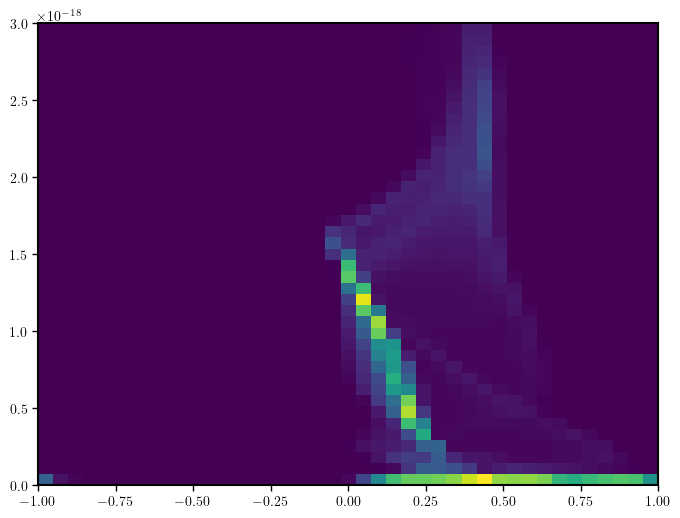

In [103]:
fig, ax = plt.subplots(figsize=(8,6))
ax.hist2d(FeXIV_emiss_diff.flatten(),FeXIV_emiss_box_cubic.flatten(),
            bins=[41,41],range=[[-1, 1], [0, 3e-18]])

In [77]:
FeX_emiss_func = interpolate.RegularGridInterpolator(points=(chianti_emiss_tbl["height"],chianti_emiss_tbl["dens"],chianti_emiss_tbl["temp"]),
                    values=chianti_emiss_tbl["fex_emiss_array"],
                    bounds_error=False,method="linear")
FeX_emiss_box = FeX_emiss_func((height_grid[:,:,:], np.log10(n[:,:,:]), np.log10(t_e[:,:,:])))

In [11]:
FeXIV_emiss_box.shape

(169, 96, 301)

In [67]:
awsom_on_disk_yz_index = np.where(np.sqrt(awsom_y_grid[:,:,150]**2 + awsom_z_grid[:,:,150]**2) <= 1) 
awsom_off_limb_yz_index = np.where(np.sqrt(awsom_y_grid[:,:,150]**2 + awsom_z_grid[:,:,150]**2) > 1) 

In [72]:
FeXIV_int_nearside = np.nansum((FeXIV_emiss_box*n)[:,:,150:]*0.01*const.R_sun.cgs.value,axis=2)
FeXIV_int_farside = np.nansum((FeXIV_emiss_box*n)[:,:,:150]*0.01*const.R_sun.cgs.value,axis=2)
FeXIV_int = np.zeros(FeXIV_emiss_box.shape[:-1])
FeXIV_int[awsom_off_limb_yz_index] = (FeXIV_int_nearside + FeXIV_int_farside)[awsom_off_limb_yz_index]
FeXIV_int[awsom_on_disk_yz_index] = FeXIV_int_nearside[awsom_on_disk_yz_index]

In [104]:
FeXIV_int_nearside_cubic = np.nansum((FeXIV_emiss_box_cubic*n)[:,:,150:]*0.01*const.R_sun.cgs.value,axis=2)
FeXIV_int_farside_cubic = np.nansum((FeXIV_emiss_box_cubic*n)[:,:,:150]*0.01*const.R_sun.cgs.value,axis=2)
FeXIV_int_cubic = np.zeros(FeXIV_emiss_box_cubic.shape[:-1])
FeXIV_int_cubic[awsom_off_limb_yz_index] = (FeXIV_int_nearside_cubic + FeXIV_int_farside_cubic)[awsom_off_limb_yz_index]
FeXIV_int_cubic[awsom_on_disk_yz_index] = FeXIV_int_nearside_cubic[awsom_on_disk_yz_index]

In [78]:
FeX_int_nearside = np.nansum((FeX_emiss_box*n)[:,:,150:]*0.01*const.R_sun.cgs.value,axis=2)
FeX_int_farside = np.nansum((FeX_emiss_box*n)[:,:,:150]*0.01*const.R_sun.cgs.value,axis=2)
FeX_int = np.zeros(FeX_emiss_box.shape[:-1])
FeX_int[awsom_off_limb_yz_index] = (FeX_int_nearside + FeX_int_farside)[awsom_off_limb_yz_index]
FeX_int[awsom_on_disk_yz_index] = FeX_int_nearside[awsom_on_disk_yz_index]

In [71]:
FeXIV_int[awsom_off_limb_yz_index].shape

(12072,)

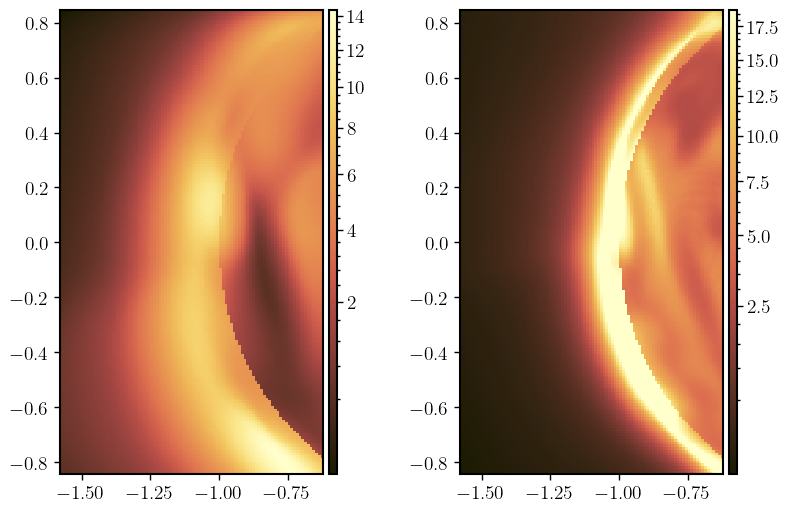

In [82]:
fig, axes = plt.subplots(1,2,figsize=(8,5),constrained_layout=True)
# FeXIV_int = np.nansum(FeXIV_emiss_box*n*0.01*const.R_sun.cgs.value,axis=2)
norm_FeXIV_int = ImageNormalize(FeXIV_int,interval=ZScaleInterval(),stretch=SqrtStretch())
im_FeXIV = axes[0].pcolormesh(awsom_y,awsom_z, FeXIV_int,norm=norm_FeXIV_int, cmap=cmcm.lajolla_r, shading="auto",rasterized=True)
plot_colorbar(im_FeXIV,axes[0])

norm_FeX_int = ImageNormalize(FeX_int,interval=ZScaleInterval(),stretch=SqrtStretch())
im_FeX = axes[1].pcolormesh(awsom_y,awsom_z, FeX_int,norm=norm_FeX_int, cmap=cmcm.lajolla_r, shading="auto",rasterized=True)
plot_colorbar(im_FeX,axes[1])

for ax_ in axes:
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)

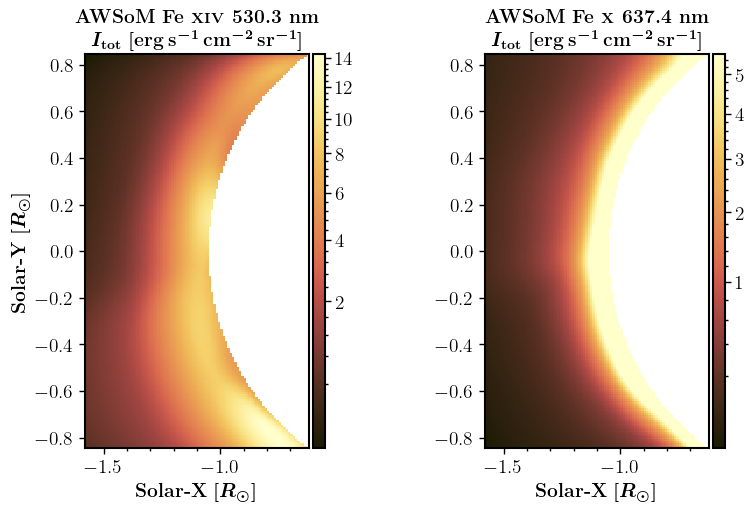

In [87]:
mask_transition_region = np.where(np.sqrt(awsom_y_grid[:,:,150]**2 + awsom_z_grid[:,:,150]**2) <= 1.05) 
FeXIV_int_mask_TR = np.copy(FeXIV_int)
FeXIV_int_mask_TR[mask_transition_region] = np.nan
FeX_int_mask_TR = np.copy(FeX_int)
FeX_int_mask_TR[mask_transition_region] = np.nan

fig, axes = plt.subplots(1,2,figsize=(8,5),constrained_layout=True)
norm_FeXIV_int_mask_TR = ImageNormalize(FeXIV_int_mask_TR,interval=ZScaleInterval(),stretch=SqrtStretch())
im_FeXIV = axes[0].pcolormesh(awsom_y,awsom_z, FeXIV_int_mask_TR,norm=norm_FeXIV_int_mask_TR, cmap=cmcm.lajolla_r, shading="auto",rasterized=True)
plot_colorbar(im_FeXIV,axes[0],width="5%")
axes[0].set_title(r"\textbf{AWSoM Fe \textsc{xiv} 530.3 nm}" + "\n" + \
                    r"$\boldsymbol{I_{\rm tot}\ \mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}}$",fontsize=14)

norm_FeX_int_mask_TR = ImageNormalize(FeX_int_mask_TR,interval=ZScaleInterval(),stretch=SqrtStretch())
im_FeX = axes[1].pcolormesh(awsom_y,awsom_z, FeX_int_mask_TR,norm=norm_FeX_int_mask_TR, cmap=cmcm.lajolla_r, shading="auto",rasterized=True)
plot_colorbar(im_FeX,axes[1],width="5%")
axes[1].set_title(r"\textbf{AWSoM Fe \textsc{x} 637.4 nm}" + "\n" + \
                    r"$\boldsymbol{I_{\rm tot}\ \mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}}$",fontsize=14)

axes[0].set_ylabel(r"\textbf{Solar-Y} $\boldsymbol{[R_\odot]}$",fontsize=14)
for ax_ in axes:
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)
    ax_.xaxis.set_minor_locator(AutoMinorLocator())
    ax_.set_xlabel(r"\textbf{Solar-X} $\boldsymbol{[R_\odot]}$",fontsize=14)

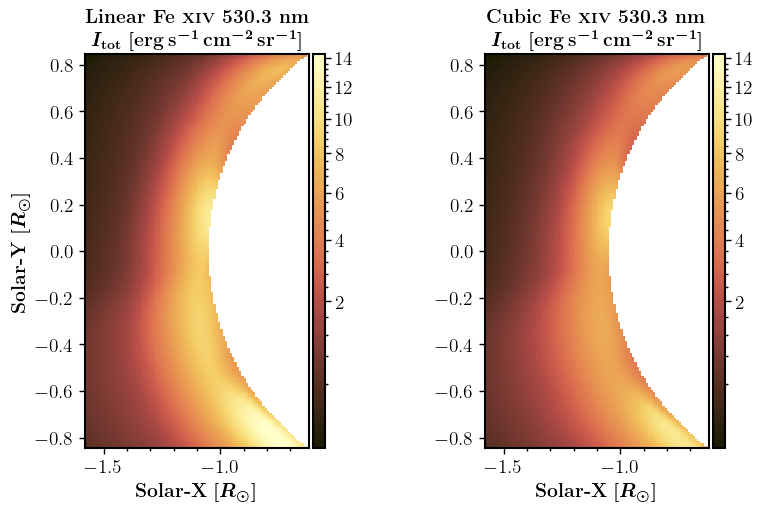

In [106]:
fig, axes = plt.subplots(1,2,figsize=(8,5),constrained_layout=True)
FeXIV_int_mask_TR_cubic = np.copy(FeXIV_int_cubic)
FeXIV_int_mask_TR_cubic[mask_transition_region] = np.nan
norm_FeXIV_int_mask_TR = ImageNormalize(FeXIV_int_mask_TR,interval=ZScaleInterval(),stretch=SqrtStretch())
im_FeXIV = axes[0].pcolormesh(awsom_y,awsom_z, FeXIV_int_mask_TR,norm=norm_FeXIV_int_mask_TR, cmap=cmcm.lajolla_r, shading="auto",rasterized=True)
plot_colorbar(im_FeXIV,axes[0],width="5%")
axes[0].set_title(r"\textbf{Linear Fe \textsc{xiv} 530.3 nm}" + "\n" + \
                    r"$\boldsymbol{I_{\rm tot}\ \mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}}$",fontsize=14)

im_FeXIV_cubic = axes[1].pcolormesh(awsom_y,awsom_z, FeXIV_int_mask_TR_cubic,norm=norm_FeXIV_int_mask_TR, cmap=cmcm.lajolla_r, shading="auto",rasterized=True)
plot_colorbar(im_FeXIV_cubic,axes[1],width="5%")
axes[1].set_title(r"\textbf{Cubic Fe \textsc{xiv} 530.3 nm}" + "\n" + \
                    r"$\boldsymbol{I_{\rm tot}\ \mathrm{[erg\,s^{-1}\,cm^{-2}\,sr^{-1}]}}$",fontsize=14)

axes[0].set_ylabel(r"\textbf{Solar-Y} $\boldsymbol{[R_\odot]}$",fontsize=14)
for ax_ in axes:
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)
    ax_.xaxis.set_minor_locator(AutoMinorLocator())
    ax_.set_xlabel(r"\textbf{Solar-X} $\boldsymbol{[R_\odot]}$",fontsize=14)

In [129]:
def calc_intensity(emiss_table,dens,temp,height,height_grid,dens_grid,te_grid,
                    off_limb_yz_index, on_disk_yz_index,method="linear"):
    emiss_func = interpolate.RegularGridInterpolator(points=(height,dens,temp),
                    values=emiss_table,
                    bounds_error=False,method=method)
    emiss_box = FeXIV_emiss_func_cubic((height_grid[:,:,:], np.log10(dens_grid[:,:,:]), np.log10(te_grid[:,:,:])))
    
    int_nearside = np.nansum((emiss_box*dens_grid)[:,:,150:]*0.01*const.R_sun.cgs.value,axis=2)
    int_farside = np.nansum((emiss_box*dens_grid)[:,:,:150]*0.01*const.R_sun.cgs.value,axis=2)
    int_tot = np.zeros(emiss_box.shape[:-1])
    int_tot[off_limb_yz_index] = (int_nearside + int_farside)[off_limb_yz_index]
    int_tot[on_disk_yz_index] = int_nearside[on_disk_yz_index]

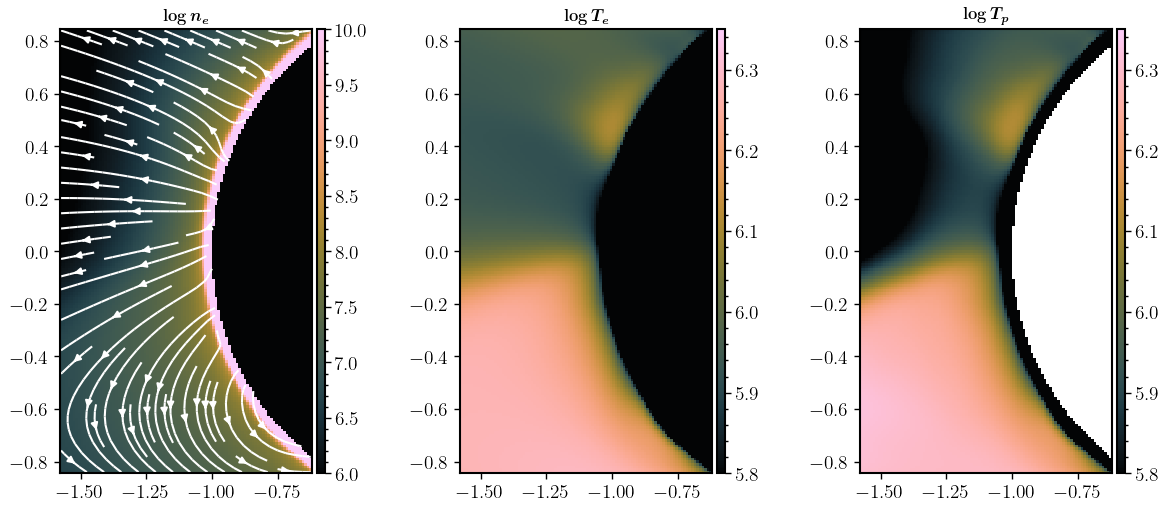

In [43]:
fig, axes = plt.subplots(1,3,figsize=(12,5),constrained_layout=True)
index_los = 150
im_n = axes[0].pcolormesh(awsom_y,awsom_z, np.log10(n[:,:,index_los]), cmap=cmcm.batlowK, 
                vmin=6,vmax=10,shading="auto",rasterized=True)
axes[0].set_title(r"$\boldsymbol{\log n_e}$")
plot_colorbar(im_n,axes[0])
axes[0].streamplot(awsom_y,awsom_z,by_rot[:,:,index_los],bz_rot[:,:,index_los],
color="white")

im_te = axes[1].pcolormesh(awsom_y,awsom_z, np.log10(t_e[:,:,index_los]), cmap=cmcm.batlowK, 
                vmin=5.8,vmax=6.35,shading="auto",rasterized=True)
plot_colorbar(im_te,axes[1])
axes[1].set_title(r"$\boldsymbol{\log T_e}$")
im_tp = axes[2].pcolormesh(awsom_y,awsom_z, np.log10(t[:,:,index_los]), cmap=cmcm.batlowK, 
                vmin=5.8,vmax=6.35,shading="auto",rasterized=True)
plot_colorbar(im_tp,axes[2])
axes[2].set_title(r"$\boldsymbol{\log T_p}$")
for ax_ in axes:
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)

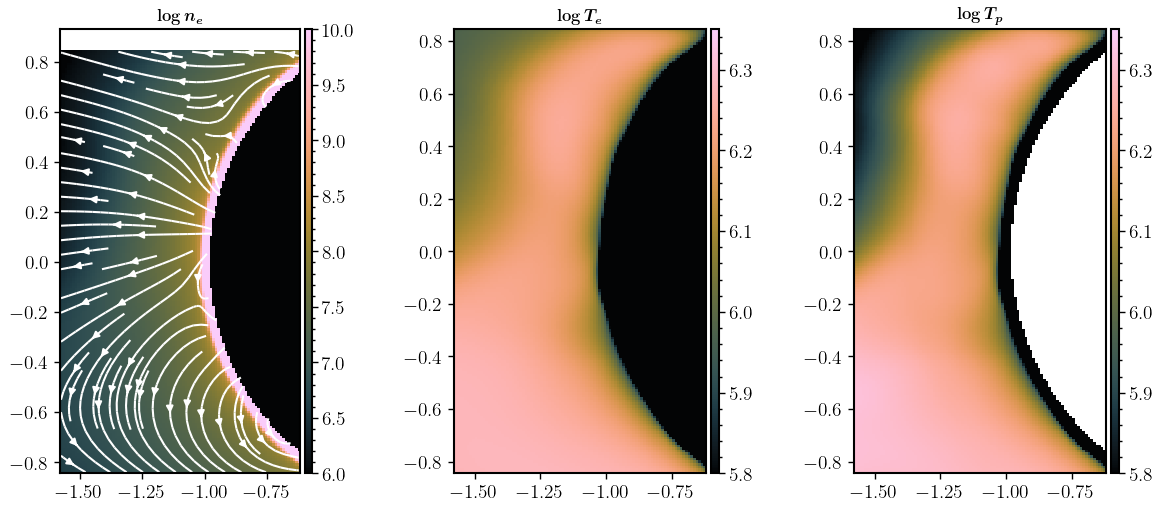

In [47]:
fig, axes = plt.subplots(1,3,figsize=(12,5),constrained_layout=True)
index_los = 170
im_n = axes[0].pcolormesh(awsom_y,awsom_z, np.log10(n[:,:,index_los]), cmap=cmcm.batlowK, 
                vmin=6,vmax=10,shading="auto",rasterized=True)
axes[0].set_title(r"$\boldsymbol{\log n_e}$")
plot_colorbar(im_n,axes[0])
axes[0].streamplot(awsom_y,awsom_z,by_rot[:,:,index_los],bz_rot[:,:,index_los],
color="white")

im_te = axes[1].pcolormesh(awsom_y,awsom_z, np.log10(t_e[:,:,index_los]), cmap=cmcm.batlowK, 
                vmin=5.8,vmax=6.35,shading="auto",rasterized=True)
plot_colorbar(im_te,axes[1])
axes[1].set_title(r"$\boldsymbol{\log T_e}$")
im_tp = axes[2].pcolormesh(awsom_y,awsom_z, np.log10(t[:,:,index_los]), cmap=cmcm.batlowK, 
                vmin=5.8,vmax=6.35,shading="auto",rasterized=True)
plot_colorbar(im_tp,axes[2])
axes[2].set_title(r"$\boldsymbol{\log T_p}$")
for ax_ in axes:
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=14)